# BI-PRS: semestrální projekt 3

Cílem třetího semestrálního projektu je analýza hrubého domácího produktu evropských zemí.

Náš tým se skládá ze tří lidí: Ruslana Orazbekova (orazbrus), Nelly Shikina (shikinel), Daria Sychova (sychodar). Reprezentatntem ve třetím semestrálním projektu je Nelly Shikina.

Nejprve určíme, který soubor dat a kterou proměnnou budeme v rámci semestrálního projektu analyzovat.

In [13]:
# K = den narození reprezentanta skupiny (1-31)
# L = počet písmen v příjmení reprezentanta
# M = ((K+L)×47)mod11+1

K <- 10
L <- nchar('Shikina')
M <- ((K + L) * 47) %% 11 + 1
print(M)
print(2011 + M)

[1] 8
[1] 2019


Uvažujeme data z roku: 2019

#### Načtěme knihovny a požadovanou datovou sadu.

In [ ]:
library(eurostat)
library(tidyverse)

In [57]:
# Načtení dat o HDP v tržních cenách v eurech na obyvatele
data <- get_eurostat("nama_10_pc", time_format = "num", filters = list(na_item = "B1GQ", unit = "CP_EUR_HAB", time = 2019))

# Zobrazení prvních řádků dat pro kontrolu
head(data)

Table nama_10_pc cached at C:\Users\User\AppData\Local\Temp\RtmpKyPUKN/eurostat/8172b3455db62aceb090af98776071df.rds



freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
A,CP_EUR_HAB,B1GQ,EU27_2020,2019,31310
A,CP_EUR_HAB,B1GQ,EU28,2019,32150
A,CP_EUR_HAB,B1GQ,EU15,2019,36580
A,CP_EUR_HAB,B1GQ,EA,2019,35010
A,CP_EUR_HAB,B1GQ,EA20,2019,34760
A,CP_EUR_HAB,B1GQ,EA19,2019,35010


Prozkoumejme, co znamenají jednotlivé sloupce datsetu.

1. **freq**: Tento sloupec udává frekvenci, s jakou jsou data zaznamenána. V tomto případě je to "A", což znamená, že data jsou roční.

2. **unit**: Sloupec `unit` označuje jednotku, v níž jsou hodnoty udávány. Zde je uvedeno "CP_EUR_HAB", což znamená "current prices, euros per inhabitant", tedy hodnoty jsou vyjádřeny v eurech na obyvatele.

3. **na_item**: Tento sloupec označuje položku Národních účtů podle zvoleného kritéria.

4. **geo**: Sloupec `geo` označuje geografickou oblast, pro kterou jsou hodnoty uvedeny.

5. **time**: Tento sloupec obsahuje rok, ke kterému se údaje vztahují.

6. **values**: Sloupec `values` obsahuje samotné hodnoty HDP vyjádřené v eurech na obyvatele pro danou oblast (země/region) a rok.

In [58]:
# Label the data with label_eurostat
data <- label_eurostat(data)
head(data)

freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 27 countries (from 2020),2019,31310
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 28 countries (2013-2020),2019,32150
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 15 countries (1995-2004),2019,36580
Annual,"Current prices, euro per capita",Gross domestic product at market prices,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",2019,35010
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area – 20 countries (from 2023),2019,34760
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area - 19 countries (2015-2022),2019,35010


Je vidět, že dataset obsahuje redundantní sloupce, takže než přejdeme k úkolům samotným, data trochu upravíme. Zbavíme se některých sloupců.

In [59]:
# Drop unnecessary columns
data <- subset(data, select = c("geo", "values"))
head(data)

geo,values
<chr>,<int>
European Union - 27 countries (from 2020),31310
European Union - 28 countries (2013-2020),32150
European Union - 15 countries (1995-2004),36580
"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",35010
Euro area – 20 countries (from 2023),34760
Euro area - 19 countries (2015-2022),35010


In [60]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] TRUE


Náš dataset má NA hodnoty. Podívejme se, kde přesně nám chybí data.

In [61]:
# Identifikace chybějících hodnot
missing_values <- is.na(data)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 2 × 2
  geo                    values
  <chr>                   <int>
1 Bosnia and Herzegovina     NA
2 Kosovo*                    NA


Chybějící hodnoty identifikovány v zemích "Bosnia a Herzegovina" a "Kosovo*". Hodnoty HDP pro tyto země v roce 2019 chybí (označeny jako NA).

In [62]:
# Identifying neighboring countries for Bosnia and Herzegovina and Kosovo
neighbors_BiH <- c("Croatia", "Serbia", "Montenegro")
neighbors_Kosovo <- c("Albania", "North Macedonia", "Serbia")

# Selecting data for neighboring countries
data_neighbors_BiH <- subset(data, geo %in% neighbors_BiH)
data_neighbors_Kosovo <- subset(data, geo %in% neighbors_Kosovo)

# Calculating the average GDP of neighboring countries
mean_BiH <- mean(data_neighbors_BiH$values, na.rm = TRUE)
mean_Kosovo <- mean(data_neighbors_Kosovo$values, na.rm = TRUE)

# Replacing missing values with the averages of neighboring countries
data$values[data$geo == "Bosnia and Herzegovina" & is.na(data$values)] <- mean_BiH
data$values[data$geo == "Kosovo*" & is.na(data$values)] <- mean_Kosovo

# Displaying the modified data
print(data[data$geo %in% c("Bosnia and Herzegovina", "Kosovo*"), ])


# A tibble: 2 × 2
  geo                    values
  <chr>                   <dbl>
1 Bosnia and Herzegovina  9460 
2 Kosovo*                 5813.


Tímto způsobem jsme nahradili chybějící hodnoty průměrným HDP sousedních zemí.

In [63]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] FALSE


Data jsou v pořádku.

## Úloha 1:

In [64]:
# Základní charakteristiky HDP
summary(data$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4820   15245   29205   33347   41773  146830 

Tyto číselné charakteristiky poskytují užitečné informace o rozdělení HDP v evropských zemích v roce 2019:

- **Minimální hodnota**: Nejnižší hodnota HDP v eurech na obyvatele z celého souboru je 4820. To ukazuje na nejmenší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

- **První kvartil (1st Qu.)**: Hodnota, pod kterou spadá první čtvrtina dat, je 15245 eur na obyvatele. To znamená, že 25 % zemí má HDP nižší než tato hodnota.

- **Medián**: Medián, což je střední hodnota datového souboru, je 29205 eur na obyvatele. To znamená, že polovina zemí má HDP nižší než tento medián a polovina má vyšší.

- **Průměr (Mean)**: Průměrná hodnota HDP v evropských zemích v roce 2019 je 33347 eur na obyvatele. To je aritmetický průměr všech hodnot HDP.

- **Třetí kvartil (3rd Qu.)**: Hodnota, pod kterou spadá třetí čtvrtina dat, je 41773 eur na obyvatele. To znamená, že 75 % zemí má HDP nižší než tato hodnota.

- **Maximální hodnota**: Nejvyšší hodnota HDP v eurech na obyvatele z celého souboru je 146830. Tato hodnota představuje nejvyšší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

Tyto statistické údaje nám poskytují přehled o rozdělení HDP a jeho variabilitě mezi evropskými zeměmi v roce 2019.

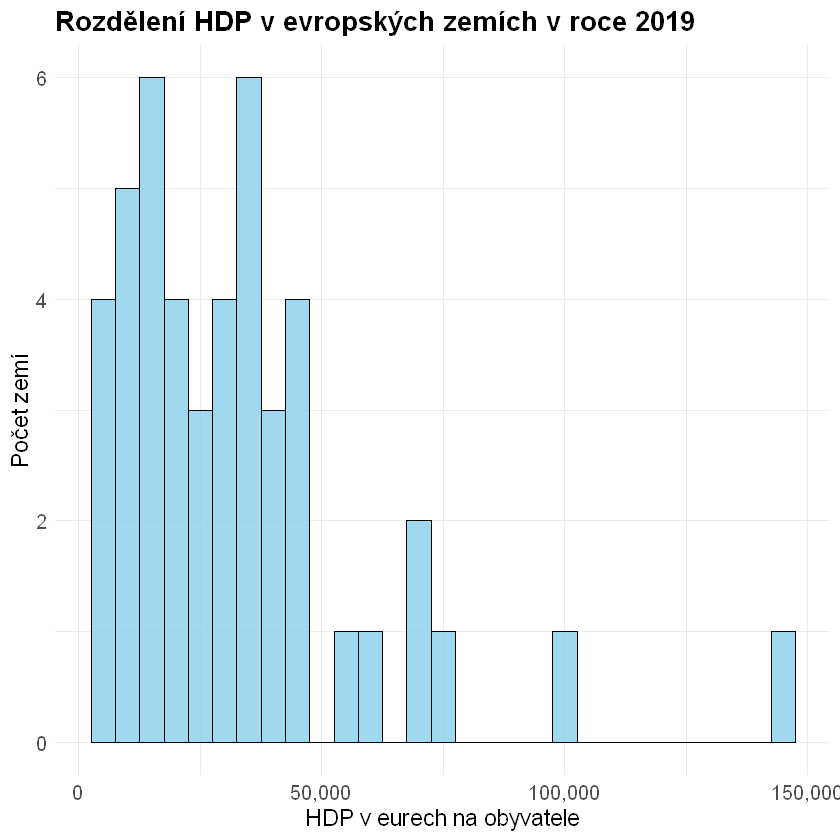

In [65]:
# Vytvoření histogramu s lepším nastavením
ggplot(data, aes(x = values)) +
  geom_histogram(binwidth = 5000, fill = "skyblue", color = "black", alpha = 0.8) +  # Alfa kanál pro průhlednost
  labs(title = "Rozdělení HDP v evropských zemích v roce 2019",
       x = "HDP v eurech na obyvatele",
       y = "Počet zemí") +
  scale_x_continuous(labels = scales::comma) +  # Přidání oddělovačů tisíců na osu x
  theme_minimal() +
  theme(plot.title = element_text(size = 16, face = "bold"),  # Velikost a styl titulku
        axis.text = element_text(size = 12),  # Velikost textu na osách
        axis.title = element_text(size = 14))  # Velikost popisků os

Tento histogram zobrazuje rozdělení hrubého domácího produktu (HDP) v evropských zemích v roce 2019. Na osu x je uvedeno HDP v eurech na obyvatele a na osu y počet zemí, které dosáhly dané úrovně HDP.

Graf ukazuje, že většina zemí má HDP mezi 10 000 a 50 000 eur na obyvatele. Existuje také menší počet zemí s HDP nad 50 000 eur na obyvatele, což může zahrnovat země s vyššími úrovněmi ekonomické prosperity.

Různé faktory mohou ovlivňovat HDP zemí. Některé z hlavních faktorů zahrnují:

* **Ekonomická politika**: Makroekonomická politika vlád, včetně monetární politiky a fiskální politiky, může mít vliv na HDP.

* **Obchodní politika**: Otevřenost země obchodu s ostatními zeměmi může ovlivnit HDP prostřednictvím exportu a importu zboží a služeb.

* **Technologický pokrok**: Inovace a technologický pokrok mohou zvyšovat produktivitu a stimulovat růst HDP.

* **Pracovní trh**: Zaměstnanost, úroveň mezd a pracovní podmínky mohou ovlivnit schopnost země generovat HDP.

* **Infrastruktura**: Kvalita infrastruktury, včetně dopravních sítí a telekomunikací, může mít vliv na efektivitu ekonomiky a tím i na HDP.

* **Politická stabilita**: Politická stabilita a právní rámec mohou ovlivnit investice a obchod, což může mít vliv na HDP.

## Úloha 2:
Pro zkoumané země můžeme zvolit následující čtyři údaje jako regresory pro analýzu vztahu k HDP:

1. **Průměrný věk obyvatelstva**: Tato numerická proměnná může poskytnout informace o demografické struktuře země a jejím vlivu na ekonomiku, jako je například pracovní síla a spotřeba.

2. **Hustota obyvatelstva**: Další numerická proměnná, která může ovlivnit HDP, je hustota obyvatelstva. Vyšší hustota obvykle znamená větší ekonomickou aktivitu a přístup k většímu trhu.

3. **Přístup k moři**: Tato kategoriální proměnná může být užitečná pro rozlišení mezi zeměmi s přístupem k moři a vnitrozemskými zeměmi. Země s přístupem k moři mohou mít výhodu v obchodu a cestovním ruchu.

4. **Měna**: Další kategoriální proměnná, která může být důležitá, je měna, kterou země používá. Země používající euro mohou mít výhodu v obchodě a stabilitě měny ve srovnání s zeměmi, které používají jiné měny.

Nyní bychom mohli použít regresní analýzu k určení vztahu mezi těmito proměnnými a HDP. Bylo by možné provést analýzu pomocí lineární regrese nebo jiných pokročilejších metod, abychom lépe porozuměli, jak tyto faktory ovlivňují ekonomický výkon zemí.

Chceme získat data o průměrném věku obyvatelstva z Eurostatu pro rok 2019 s pomocí identifikátoru MEDAGEPOP pro střední věk obyvatelstva. Vytvořím dotaz do databáze Eurostatu, abychom mohli získat požadovaná data.

In [66]:
# Dotaz na data o průměrném věku obyvatelstva za rok 2019
data_age <- get_eurostat("eq_pop04", filters = list(time="2019", indic_de = "MEDAGEPOP"))
# Zobrazení prvních řádků dat
head(data_age)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\User\AppData\Local\Temp\RtmpKyPUKN/eurostat/afdd4e6e27b94a0fbe944e9f388e8116.rds

Table  eq_pop04  read from cache file:  C:\Users\User\AppData\Local\Temp\RtmpKyPUKN/eurostat/afdd4e6e27b94a0fbe944e9f388e8116.rds



freq,indic_de,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,MEDAGEPOP,EU27_2020,2019-01-01,43.7
A,MEDAGEPOP,EA20,2019-01-01,NA
A,MEDAGEPOP,EA19,2019-01-01,44.3
A,MEDAGEPOP,BE,2019-01-01,41.7
A,MEDAGEPOP,BG,2019-01-01,44.5
A,MEDAGEPOP,CZ,2019-01-01,42.6


In [69]:
# Drop unnecessary columns
data_age <- subset(data_age, select = c("geo", "values"))
data_age <- label_eurostat(data_age)
head(data_age)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),43.7
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),44.3
Belgium,41.7
Bulgaria,44.5
Czechia,42.6


Pro získání dat o hustotě obyvatelstva z Eurostatu pro rok 2019 s pomocí identifikátoru tps00003 pro hustotu obyvatelstva vytvořím dotaz do databáze Eurostatu.

In [67]:
data_density <- get_eurostat("tps00003", filters = list(time="2019"))

# Zobrazení prvních řádků dat
head(data_density)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\User\AppData\Local\Temp\RtmpKyPUKN/eurostat/7f206ce4fb9af7257f000f792c782fa5.rds

Table  tps00003  read from cache file:  C:\Users\User\AppData\Local\Temp\RtmpKyPUKN/eurostat/7f206ce4fb9af7257f000f792c782fa5.rds



freq,unit,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,PER_KM2,EU27_2020,2019-01-01,109.0
A,PER_KM2,EA20,2019-01-01,NA
A,PER_KM2,EA19,2019-01-01,NA
A,PER_KM2,BE,2019-01-01,377.3
A,PER_KM2,BG,2019-01-01,63.4
A,PER_KM2,CZ,2019-01-01,138.2


In [71]:
# Identifikace chybějících hodnot
missing_values <- is.na(data_age)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data_age[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 5 × 2
  geo                                  values
  <chr>                                 <dbl>
1 Euro area – 20 countries (from 2023)     NA
2 Metropolitan France                      NA
3 Moldova                                  NA
4 Russia                                   NA
5 San Marino                               NA


In [70]:
# Drop unnecessary columns
data_density <- subset(data_density, select = c("geo", "values"))
data_density <- label_eurostat(data_density)
head(data_density)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),109.0
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),NA
Belgium,377.3
Bulgaria,63.4
Czechia,138.2


In [72]:
# Identifikace chybějících hodnot
missing_values <- is.na(data_density)

# Zobrazení řádků s chybějícími hodnotami
rows_with_missing <- data_density[apply(missing_values, 1, any), ]
print(rows_with_missing)


# A tibble: 3 × 2
  geo                                   values
  <chr>                                  <dbl>
1 Euro area – 20 countries (from 2023)      NA
2 Euro area - 19 countries  (2015-2022)     NA
3 United Kingdom                            NA
